# When Do Different Types of Collisions Occur?

Understanding when the different types of collisions occur can help determine the cause of collisions and suggest possible mitigations to reduce collisions, injuries, and deaths.

### Definitions
- __Collision:__ A motor vehicle collision involving injuries, deaths, or a significant amount of property damage (~> $1000) reported on a New York State form, MV104-AN
- __Serious Collision:__ A collision where at least one person is injured or killed
- __Non-Motorist:__ A pedestrian or cyclist (not the driver or passenger of a motor vehicle)


### Data Sources
- Collision data obtained from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95
- Data was processed by running `process_raw.data.py` which saves processed data to local directory specified in `process_raw.data.py` script

In [1]:
import os.path
from datetime import datetime
import pandas as pd
from src import visualizations as viz

# Parameters 

In [2]:
PROCESSED_CRASH_DATA = "data/processed/crashes.pkl"
IMG_DIR = "website/when"

# Constants

In [3]:
DAY_OF_WEEK_MAP = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday",
}
MONTHS_MAP = {
    1: "Jan",
    2: "Feb",
    3: "Mar",
    4: "Apr",
    5: "May",
    6: "Jun",
    7: "Jul",
    8: "Aug",
    9: "Sep",
    10: "Oct",
    11: "Nov",
    12: "Dec",
}
SEASONS = ["Winter", "Spring", "Summer", "Fall"]

# Helper Functions

In [4]:
def make_collision_groupby(df, groupby_col, divisor):
    """Returns a pd.DataFrame of groupby aggregates for collisions, serious collisions, 
    and non-motorist collisions"""
    ret_df = pd.DataFrame()
    ret_df["Collisions"] = df.groupby(by=groupby_col)["ID"].count() / divisor
    ret_df["Serious Collisions"] = df.groupby(by=groupby_col)["serious"].sum() / divisor
    ret_df["Non-Motorist Serious"] = (
        df.groupby(by=groupby_col)["non-motorist"].sum() / divisor
    )
    return ret_df


def make_week_crosstab(df, divisor, day_of_week_map=DAY_OF_WEEK_MAP, dt_col="datetime"):
    """Returns an hour / day-of-week crosstab scaled by a divisor"""
    ct = pd.crosstab(index=df[dt_col].dt.dayofweek, columns=df[dt_col].dt.hour)
    ct = ct.rename(index=day_of_week_map)
    ct /= divisor  # scale crosstab by divisor
    return ct


def make_heatmap_labels(
    title, x_label="Hour of Day", y_label="", cbar_label="Number of Collisions per Hour"
):
    """Returns a dictionary of labels for a 2D heatmap"""
    ct_labels = {
        "title": title,
        "x_label": x_label,
        "y_label": y_label,
        "cbar_label": cbar_label,
    }
    return ct_labels


def get_crosstab_min_max(df, col, categories, divisor=None):
    """
    Returns the absolute min and absolute max values of crosstabs across all categories. 
    Used to ensure that different heatmaps have the same scale.
    """
    max_val = float("-inf")
    min_val = float("inf")
    for cat in categories:
        is_true = df[col].isin([cat])
        idx = df.loc[is_true, "datetime"].dt.dayofweek
        cols = df.loc[is_true, "datetime"].dt.hour
        ct = pd.crosstab(index=idx, columns=cols)
        min_val = min(min_val, min(ct.min()))
        max_val = max(max_val, max(ct.max()))
    if divisor:
        min_val /= divisor
        max_val /= divisor
    return min_val, max_val

In [5]:
crashes = pd.read_pickle(PROCESSED_CRASH_DATA)

Calculating time-related values for scaling values

In [6]:
time_range = (
crashes["datetime"].max() - crashes["datetime"].min()
)  # Pandas Timedelta object
total_days = time_range.round("1d").days
total_years = total_days / 365.25
total_weeks = total_days / 7

# What are overall trends in collisions over the last few years? 

In [7]:
# selecting years with complete data 
start = datetime(year=2013, month=1, day=1)
end = datetime(year=2021, month=1, day=1)
complete = crashes[crashes["datetime"].between(start, end, inclusive="left")].copy()

### Collisions
- From 2013 to 2019 there were:
    - Between 203k and 232k collisions per year, an __average of ~550 to ~630 a day__
    - Between 37k and 45k collisions per year that injured or killed at least one person, an __average of ~100 to ~120 a day__
    - Between 14k and 16k collisions per year that injured or killed at least one pedestrians or cyclist, an __average of ~38 to ~44 a day__
- Serious collisions trended upwards from 2013 to 2019
- The trend in collisions with pedestrians and cyclists was approximately flat
- Collisions dropped sharply in 2020 as traffic levels dropped in response to COVID-19
- Serious collisions and collisions with pedestrians and cyclists did not drop as much as overall collisions, indicating that the average collision in 2020 was more dangerous

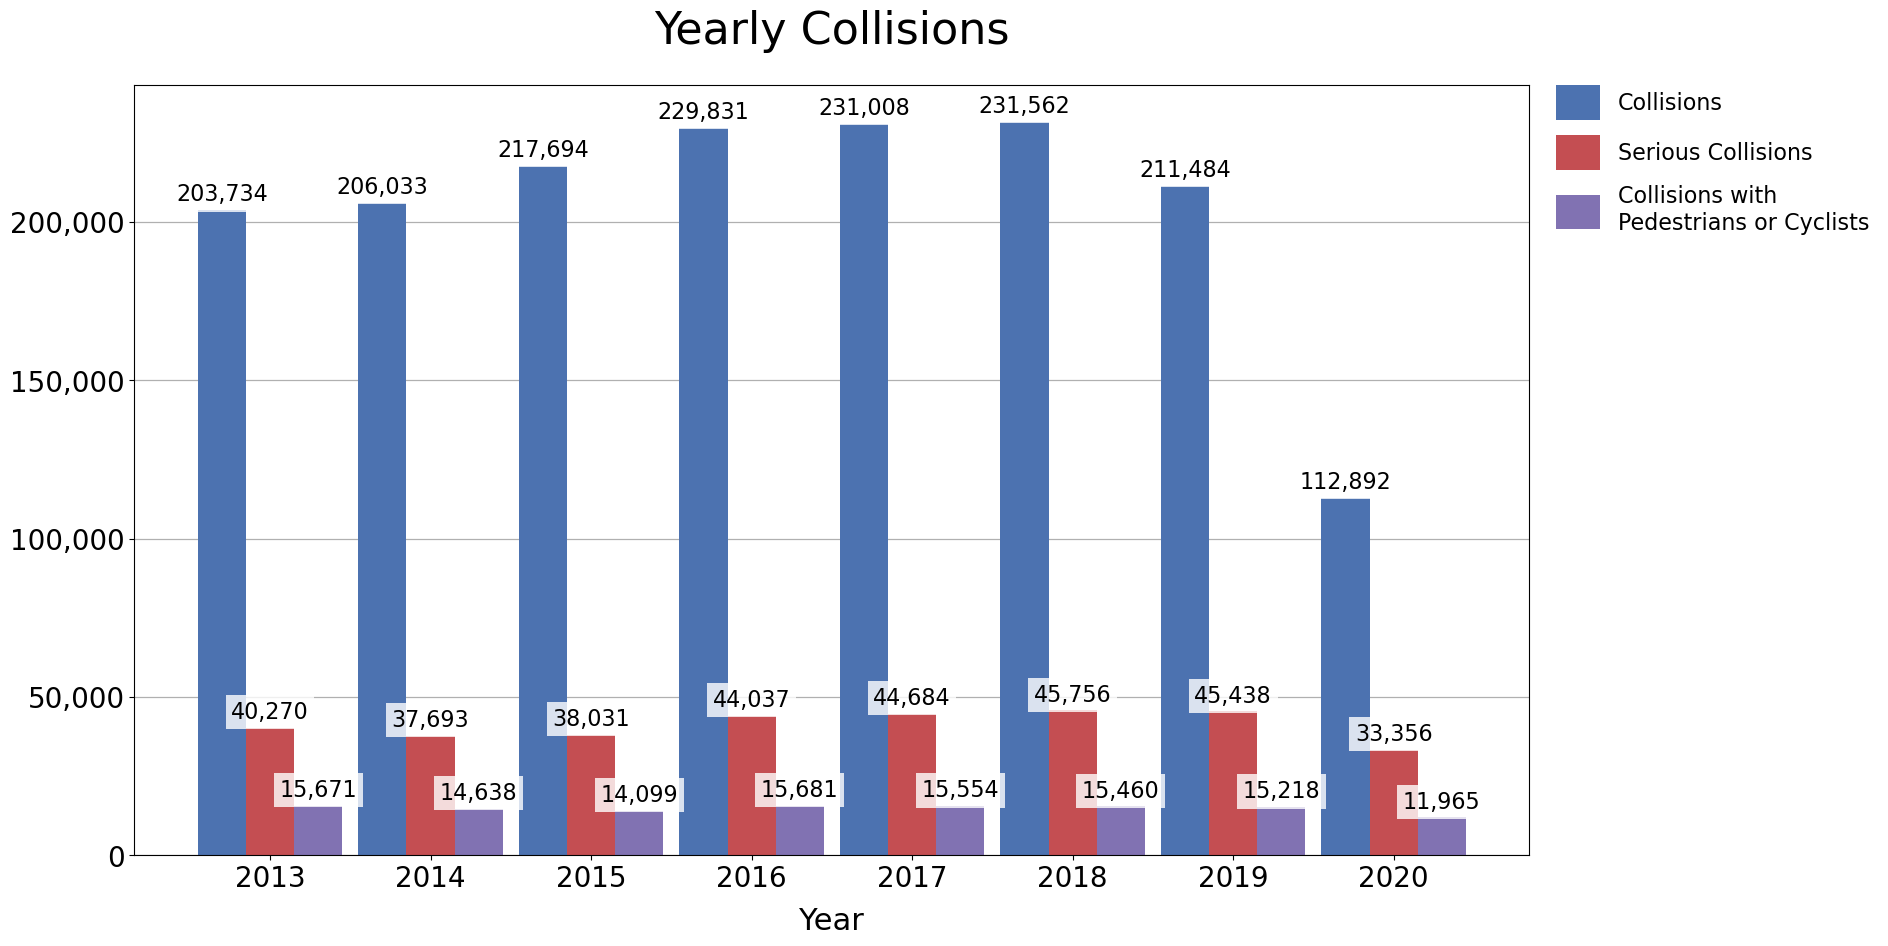

In [8]:
year_groupby = make_collision_groupby(complete, complete["datetime"].dt.year, divisor=1)
year_labels = {"title": "Yearly Collisions", "y_label": "", "x_label": "Year"}
groups = ["Collisions", "Serious Collisions", "Collisions with \nPedestrians or Cyclists"]
viz.make_grouped_bar_chart(
    year_groupby,
    **year_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    legend_handleheight=2.0,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "yearly_collisions.png"),
)

Preparing yearly injury and death counts

In [9]:
sum_fields = [
    "INJURED",
    "PEDESTRIAN INJURED",
    "CYCLIST INJURED",
    "KILLED",
    "PEDESTRIAN KILLED",
    "CYCLIST KILLED",
]
losses = complete.groupby(by=complete["datetime"].dt.year)[sum_fields].sum()
losses["Pedestrians and Cyclists Injured"] = (
    losses["PEDESTRIAN INJURED"] + losses["CYCLIST INJURED"]
)
losses["Pedestrians and Cyclists Killed"] = (
    losses["PEDESTRIAN KILLED"] + losses["CYCLIST KILLED"]
)
losses = losses.rename(columns={"INJURED": "Total Injured", "KILLED": "Total Killed"})
fields_to_keep = [
    "Total Injured",
    "Pedestrians and Cyclists Injured",
    "Total Killed",
    "Pedestrians and Cyclists Killed",
]
losses = losses[fields_to_keep]

### Injuries and Deaths

#### Overall Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 51k and 62k injuries per year, an __average of ~140 to ~170 a day__
    - __Between 230 and 300 people killed in collisions each year__
- Total injuries trended upwards from 2013 to 2019
- __While there were ~46% fewer collisions in 2020 than in 2019, injuries only fell ~27% and 2020 fatalities were the highest since 2013__

#### Pedestrian / Cyclist (Non-Motorist) Injuries and Deaths
- From 2013 to 2019 there were:
    - Between 14k and 16k pedestrians and cyclists injured per year, an __average of ~38 to ~44 a day__
    - __Between 130 and 190 pedestrians and cyclists killed in collisions each year__
- Total pedestrian and cyclist injuries were approximately flat from 2013 to 2019

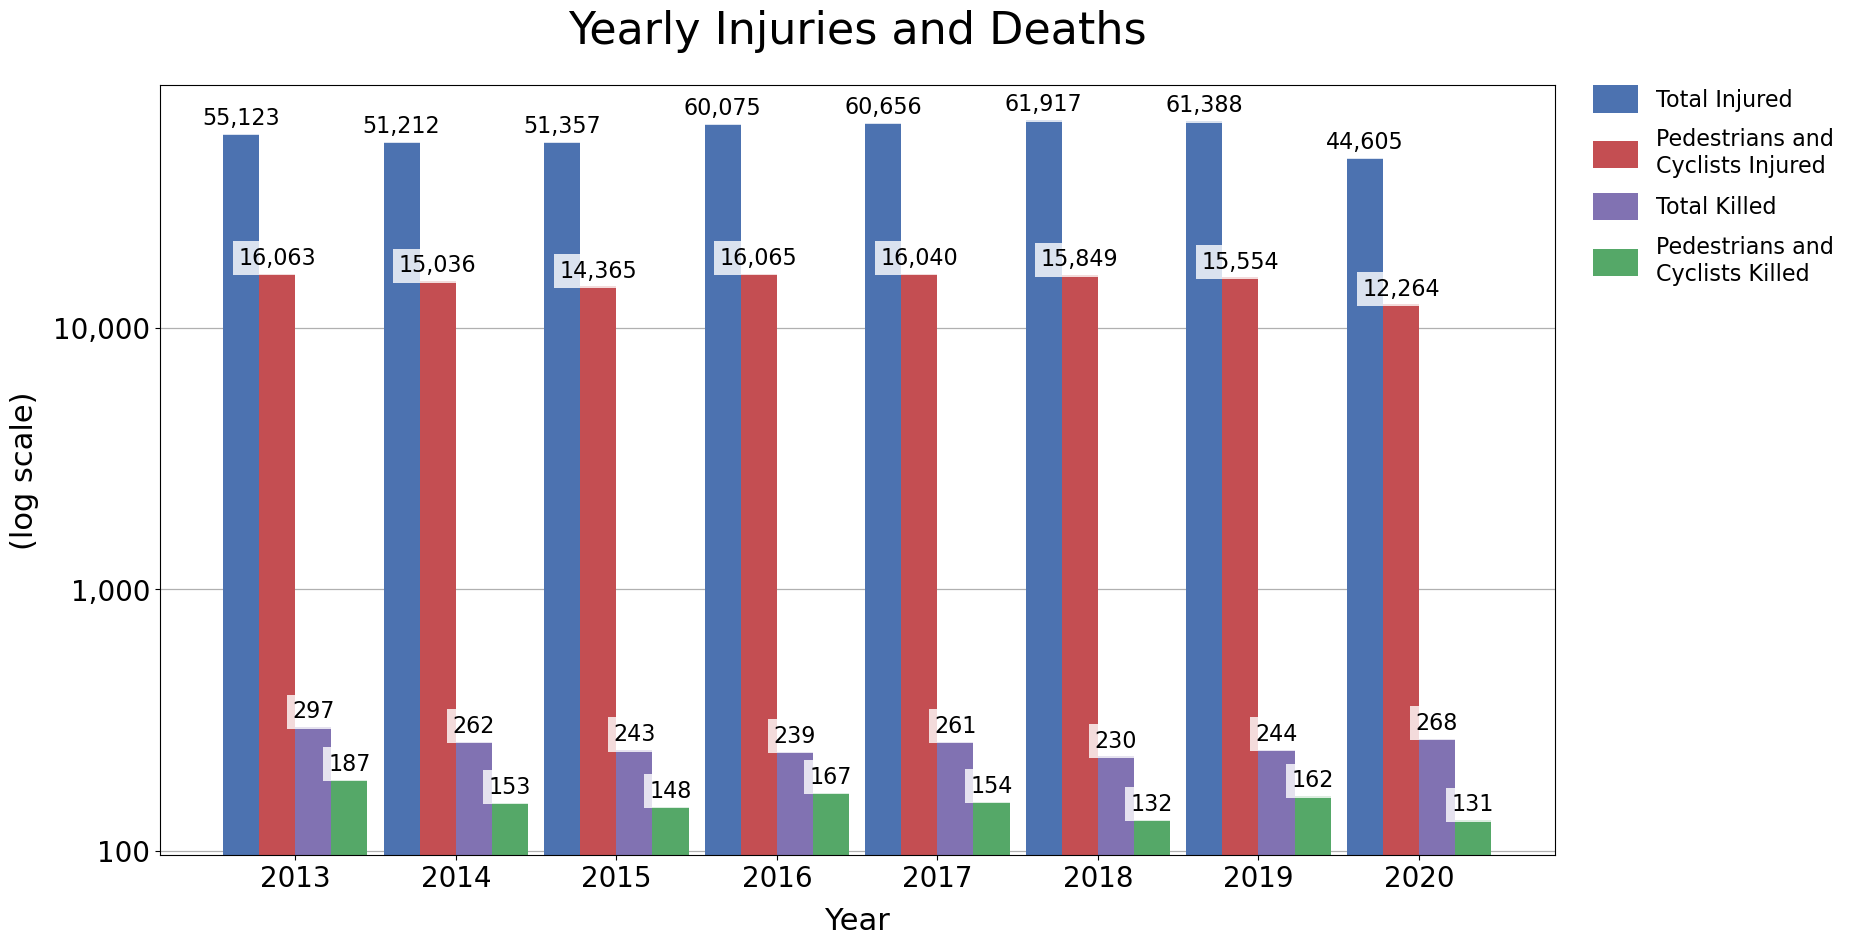

In [10]:
losses_labels = {
    "title": "Yearly Injuries and Deaths",
    "y_label": "(log scale)",
    "x_label": "Year",
}
groups = ["Total Injured", "Pedestrians and \nCyclists Injured", "Total Killed", "Pedestrians and \nCyclists Killed"]
viz.make_grouped_bar_chart(
    losses,
    **losses_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    logscale=True,
    minor_ticks_off=True,
    ylabel_rotation="vertical",
    ylabel_pad=10,
    legend_bbox=(1.07, 0.9),
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "yearly_injuries_deaths.png"),
)

# 1D views on when collisions are most common

### Seasonal Variation

- Summer tends to have the most serious collisions
- Fall tends to have the most overall collisions and collisions with pedestrians and cyclists

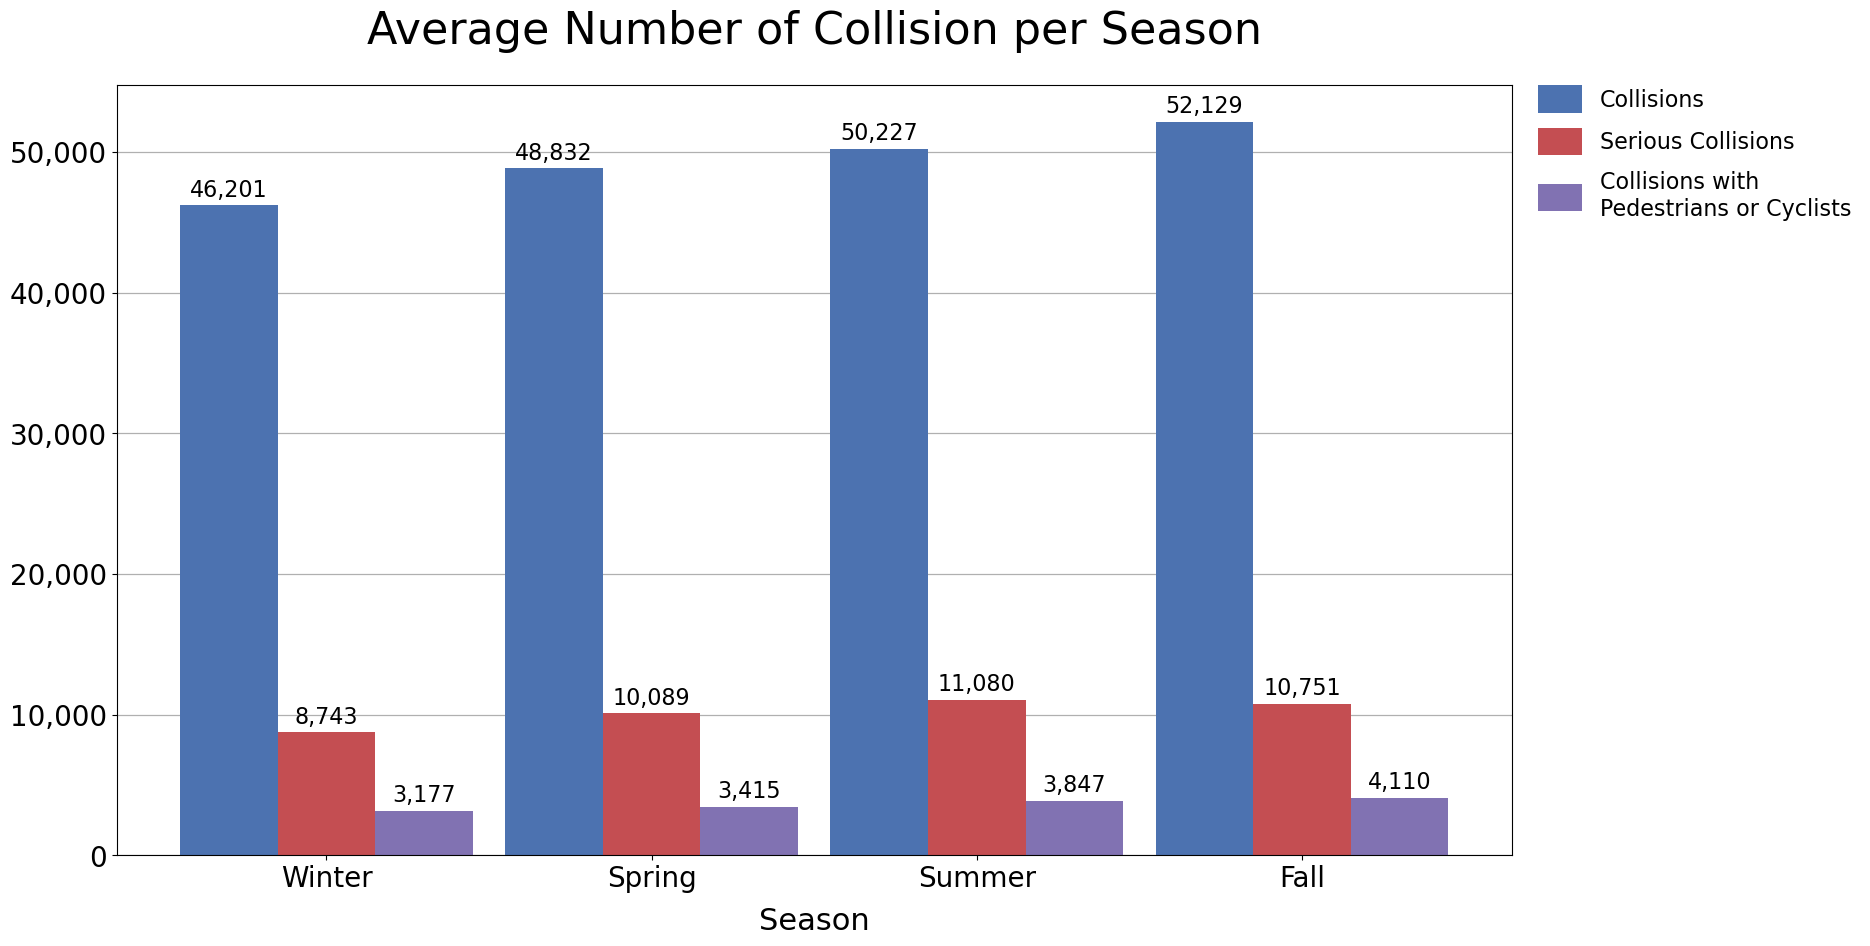

In [11]:
season_groupby = make_collision_groupby(crashes, "season", total_years)
season_groupby = season_groupby.reindex(["Winter", "Spring", "Summer", "Fall"])
season_labels = {
    "title": "Average Number of Collision per Season",
    "y_label": "",
    "x_label": "Season",
}
groups = ["Collisions", "Serious Collisions", "Collisions with \nPedestrians or Cyclists"]
viz.make_grouped_bar_chart(
    season_groupby,
    **season_labels,
    legend_labels=groups, 
    colors=viz.CYCLE_COLORS,
    save=os.path.join(IMG_DIR, "1D", "seasons.png"),
)

### Monthly Variation

- October leads in all three categories of collisions
- Serious collisions are particularly elevated from June to October

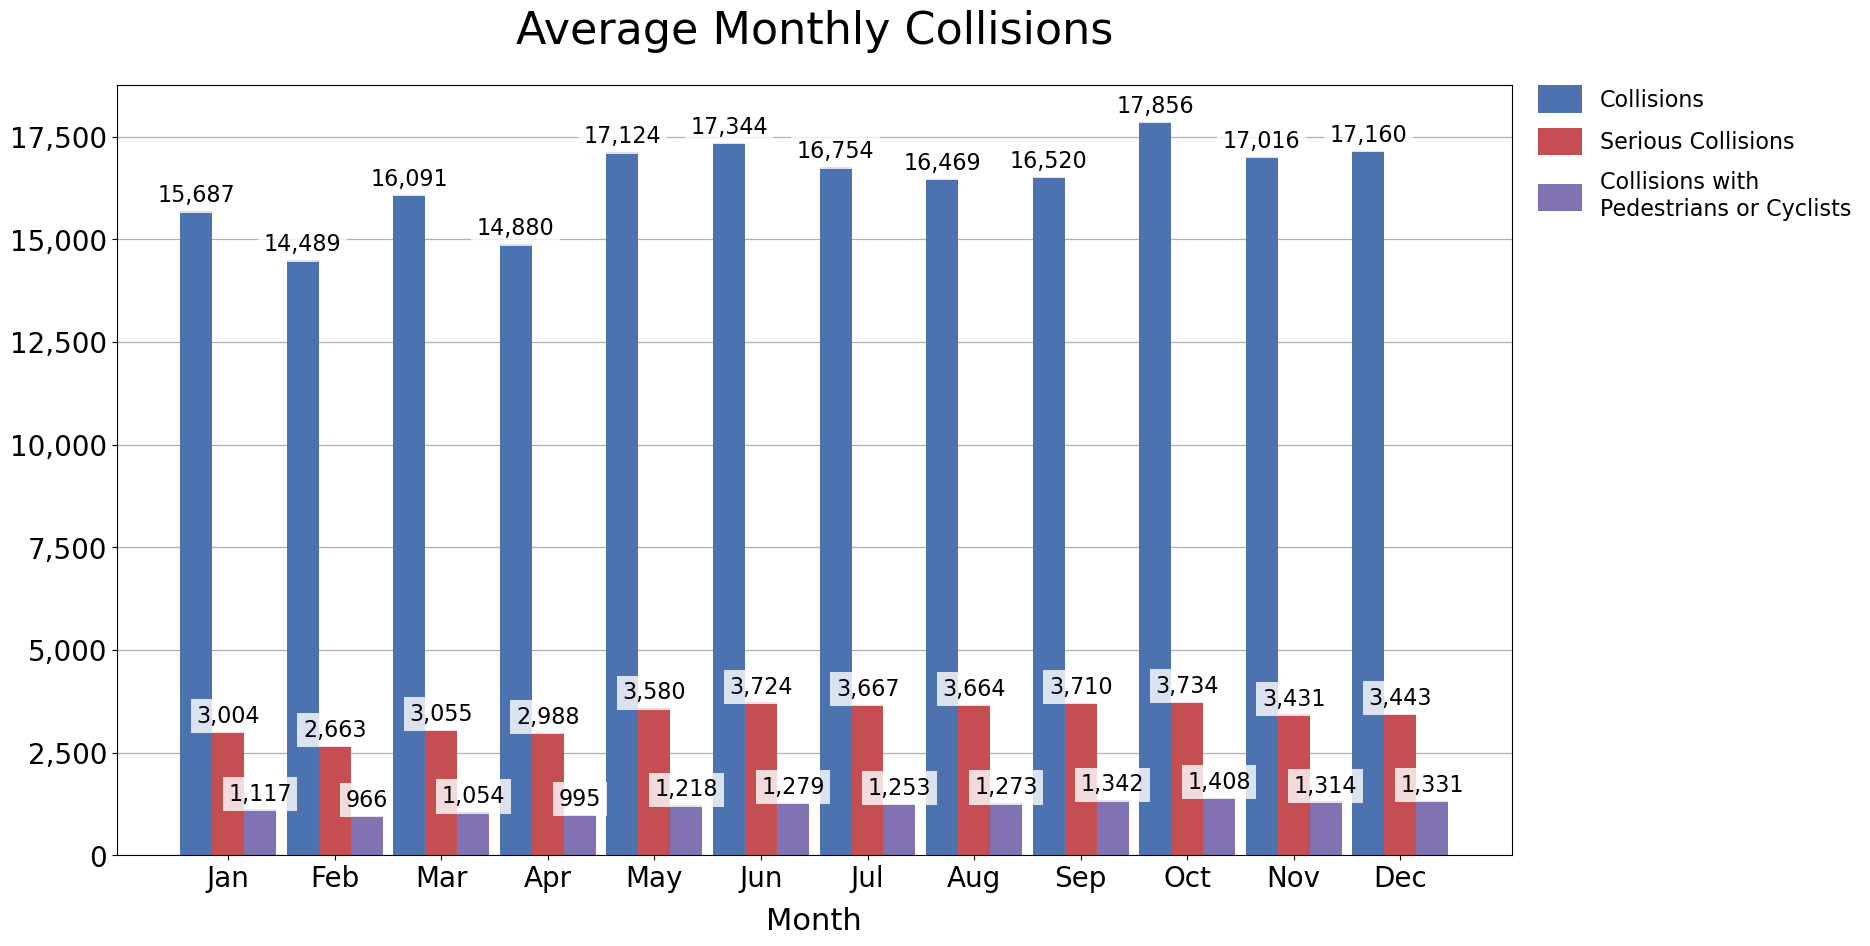

In [12]:
month_groupby = make_collision_groupby(
    crashes, crashes["datetime"].dt.month, total_years
)
month_groupby.index = month_groupby.index.map(MONTHS_MAP)
month_labels = {
    "title": "Average Monthly Collisions",
    "y_label": "",
    "x_label": "Month",
}
groups = ["Collisions", "Serious Collisions", "Collisions with \nPedestrians or Cyclists"]
viz.make_grouped_bar_chart(
    month_groupby,
    **month_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    bar_label_bbox={"facecolor": "white", "edgecolor": "none", "alpha": 0.8},
    save=os.path.join(IMG_DIR, "1D", "monthly.png"),
)

### Weekly Variation

All categories of collisions are most common on Fridays and least common on Sundays

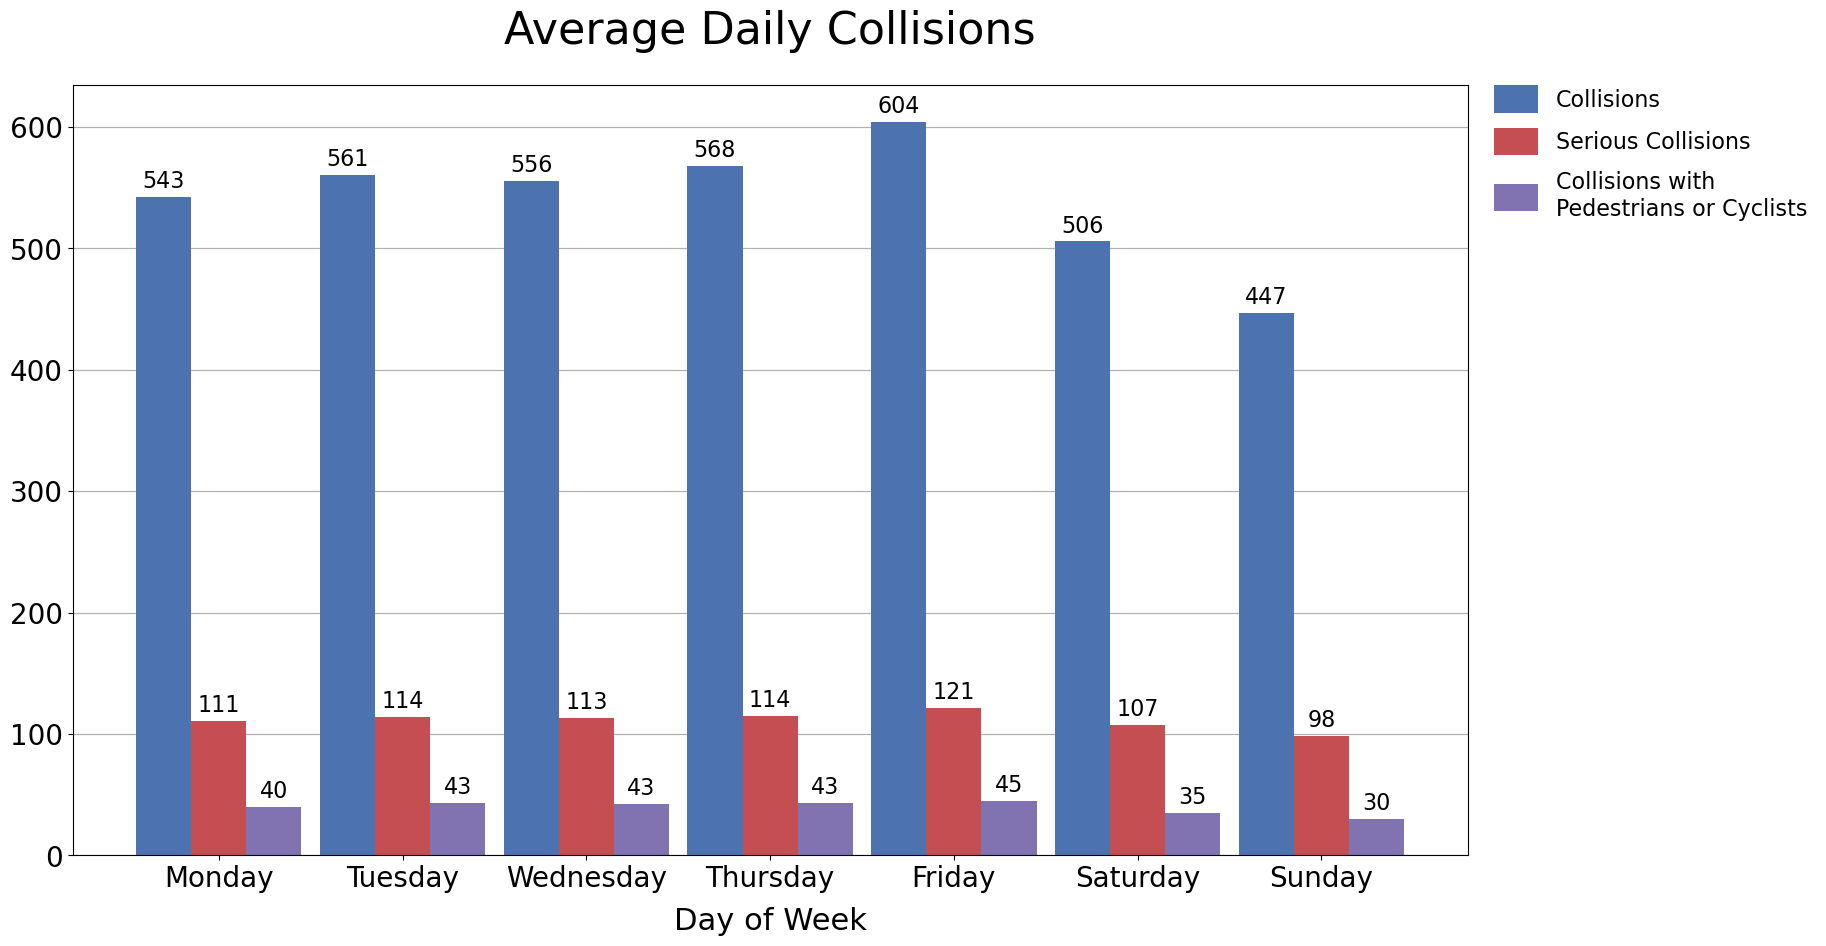

In [13]:
day_groupby = make_collision_groupby(
    crashes, crashes["datetime"].dt.dayofweek, total_weeks
)
day_groupby.index = day_groupby.index.map(DAY_OF_WEEK_MAP)
day_labels = {
    "title": "Average Daily Collisions",
    "y_label": "",
    "x_label": "Day of Week",
}
groups = ["Collisions", "Serious Collisions", "Collisions with \nPedestrians or Cyclists"]
viz.make_grouped_bar_chart(
    day_groupby,
    **day_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    save=os.path.join(IMG_DIR, "1D", "weekly.png"),
)

### Daily Variation

All categories of collisions are most common in the later afternoon / early evening, ~3-7pm (hours 15-19).

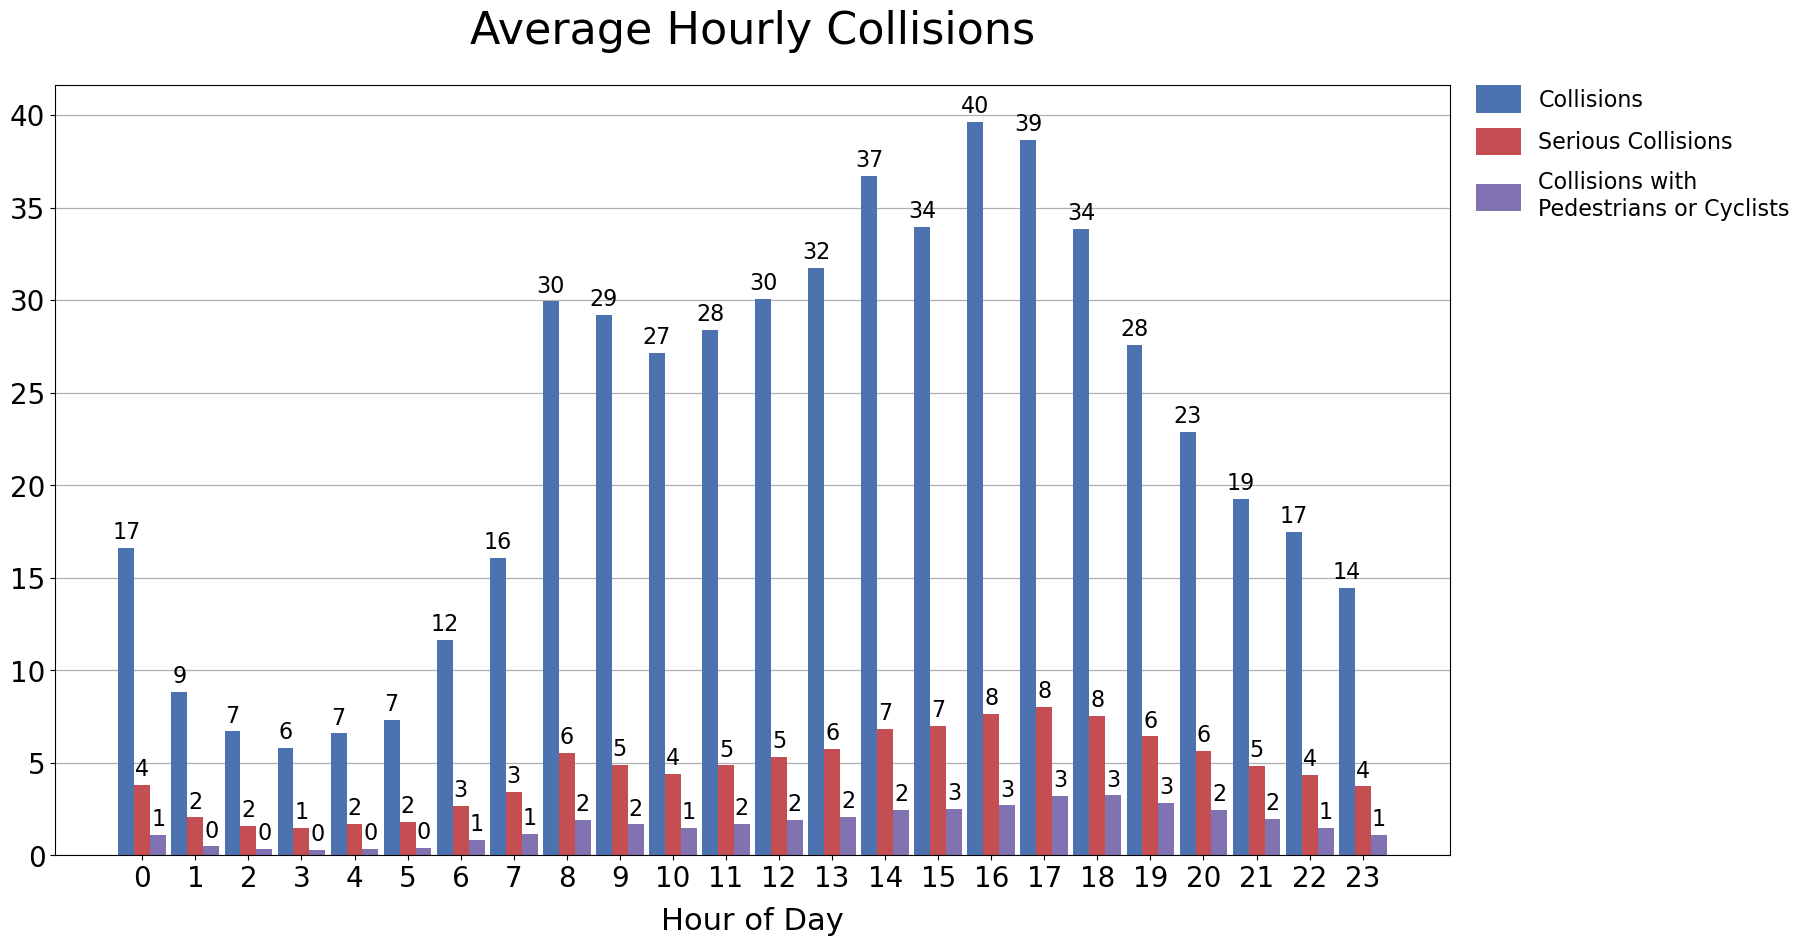

In [14]:
hour_groupby = make_collision_groupby(crashes, crashes["datetime"].dt.hour, total_days)
hour_labels = {
    "title": "Average Hourly Collisions",
    "y_label": "",
    "x_label": "Hour of Day",
}
groups = ["Collisions", "Serious Collisions", "Collisions with \nPedestrians or Cyclists"]
viz.make_grouped_bar_chart(
    hour_groupby,
    **hour_labels,
    legend_labels=groups,
    colors=viz.CYCLE_COLORS,
    save=os.path.join(IMG_DIR, "1D", "hourly.png"),
)

# 2D views on when collisions are most common

### All Collisions

- Collisions are most common on weekdays in the afternoon / early evening, from approximately 2pm to 7pm (hours 14-19)
- Friday afternoons / early evenings are particularly bad
- Collisions are also elevated during the weekday morning commute, approximately 8am to 10am (hours 8 - 10)
- Early morning collisions, midnight to 6am (hours 0-6), are elevated on the weekends


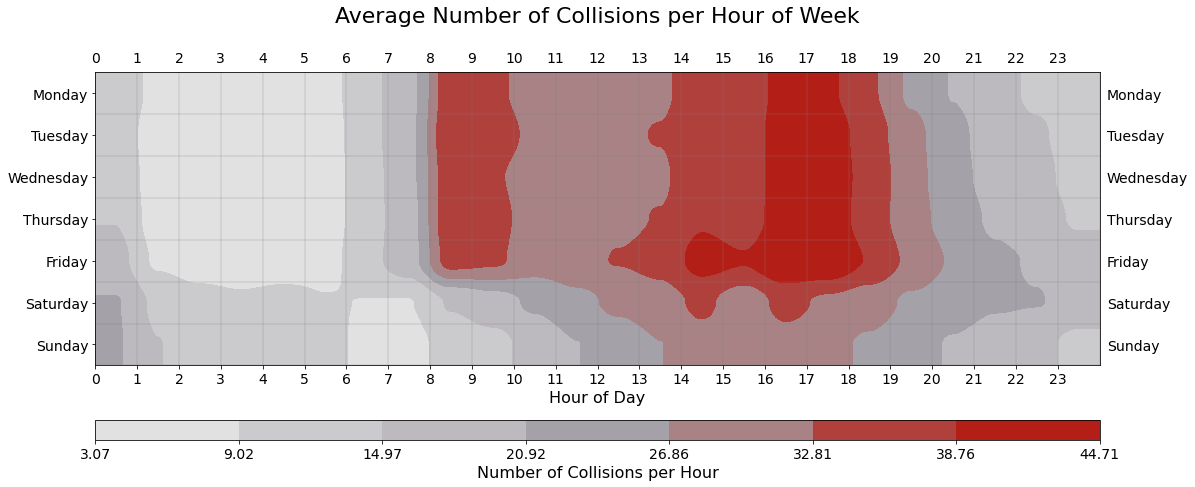

In [15]:
crash_ct = make_week_crosstab(crashes, total_weeks)
ct_labels = make_heatmap_labels("Average Number of Collisions per Hour of Week")
viz.make_heat_map(
    crash_ct,
    ct_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "2D", "crash_heat.png"),
)

### Serious Collisions

The weekly pattern of serious collisions is similar to overall collisions with the exception that serious collisions are less common during the weekday morning commute.

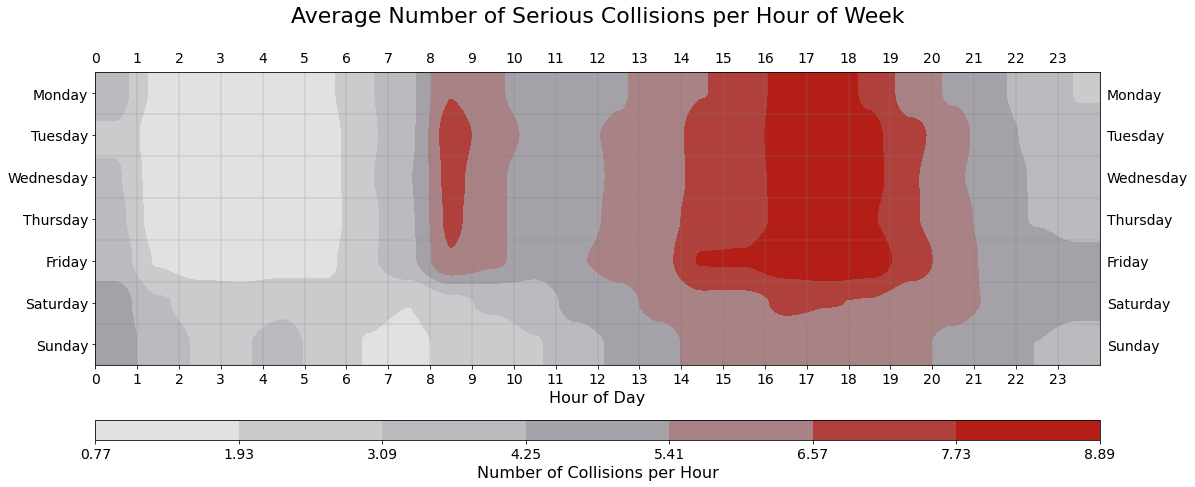

In [16]:
serious = crashes[crashes["serious"]]
serious_ct = make_week_crosstab(serious, total_weeks)
serious_labels = make_heatmap_labels(
    "Average Number of Serious Collisions per Hour of Week"
)
viz.make_heat_map(
    serious_ct,
    serious_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "2D", "serious_heat.png"),
)

### Fatal Collisions
- The most prominent cluster of fatalities occurs Saturday and Sunday mornings between 3am and 5am. Intoxication may be presumed to be a major factor in these fatal collisions. Many bars and clubs close around 4am in NYC. 
- A secondary cluster of fatalities occurs Fridays and Saturdays between 5pm and 7pm (hours 17-19)
- Fatal collisions are generally elevated from 5pm to 1am (hours 17 - 1)

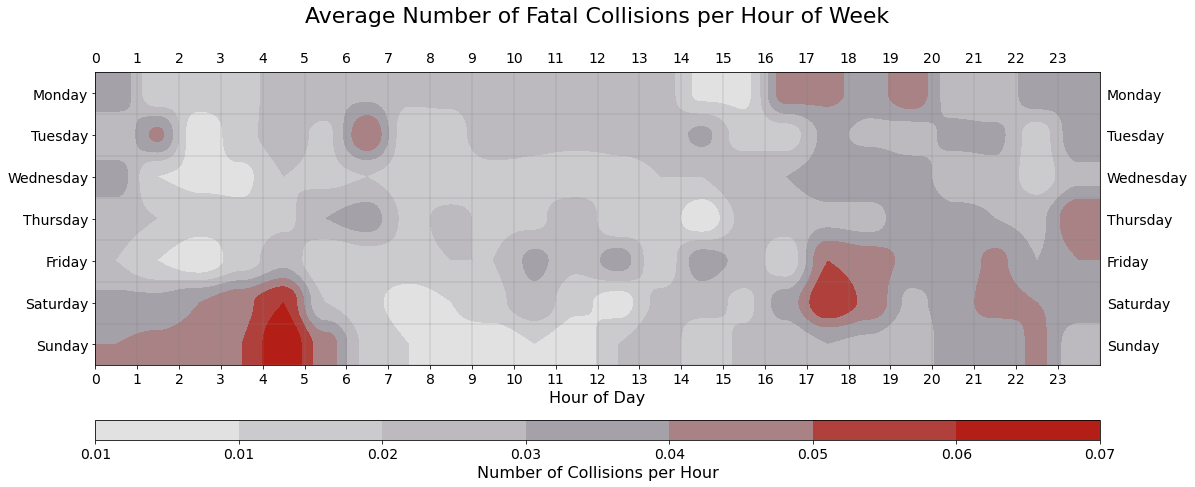

In [17]:
fatal = crashes[crashes["KILLED"] > 0]
fatal_ct = make_week_crosstab(fatal, total_weeks)
fatal_labels = make_heatmap_labels(
    "Average Number of Fatal Collisions per Hour of Week"
)
viz.make_heat_map(
    fatal_ct,
    fatal_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "2D", "fatal_heat.png"),
)

### Collisions with Pedestrians and Cyclists

- Collisions with pedestrians and cyclists are most common during weekday afternoons and evenings
- Additionally, collisions are elevated weekday mornings and weekend afternoons and evenings

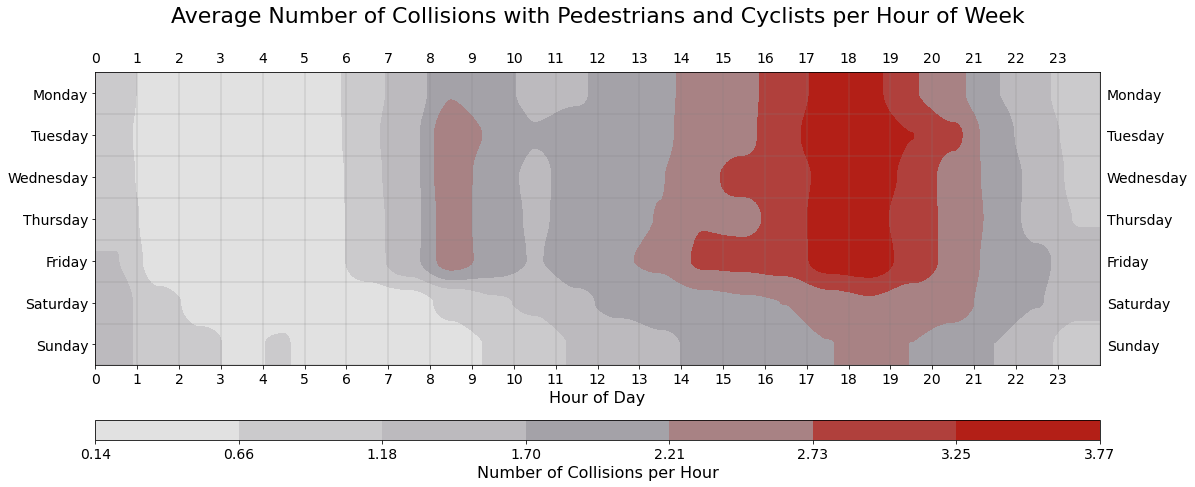

In [18]:
non_motorist = crashes[crashes["non-motorist"]]
non_motorist_ct = make_week_crosstab(non_motorist, total_weeks)
non_motorist_labels = make_heatmap_labels(
    "Average Number of Collisions with Pedestrians and Cyclists per Hour of Week"
)
viz.make_heat_map(
    non_motorist_ct,
    non_motorist_labels,
    colors=viz.HEATMAP_COLORS,
    interpolation="hanning",
    save=os.path.join(IMG_DIR, "2D", "non_motor_heat.png"),
)

### Weekly Collisions Through the Seasons

- Weekday morning collisions are least common during the Summer and spike in the Fall
- Afternoon and evening collisions are less common in the winter

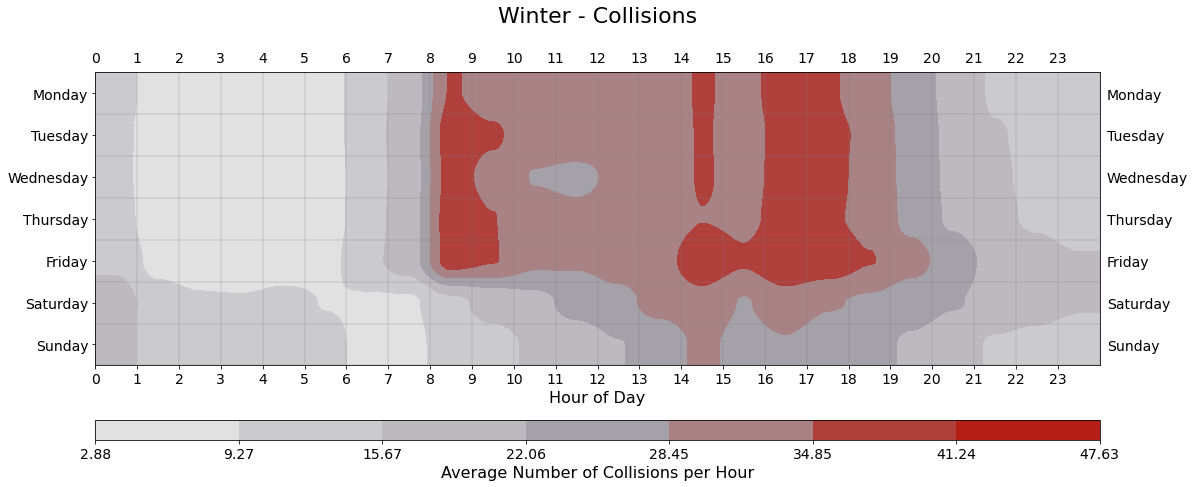

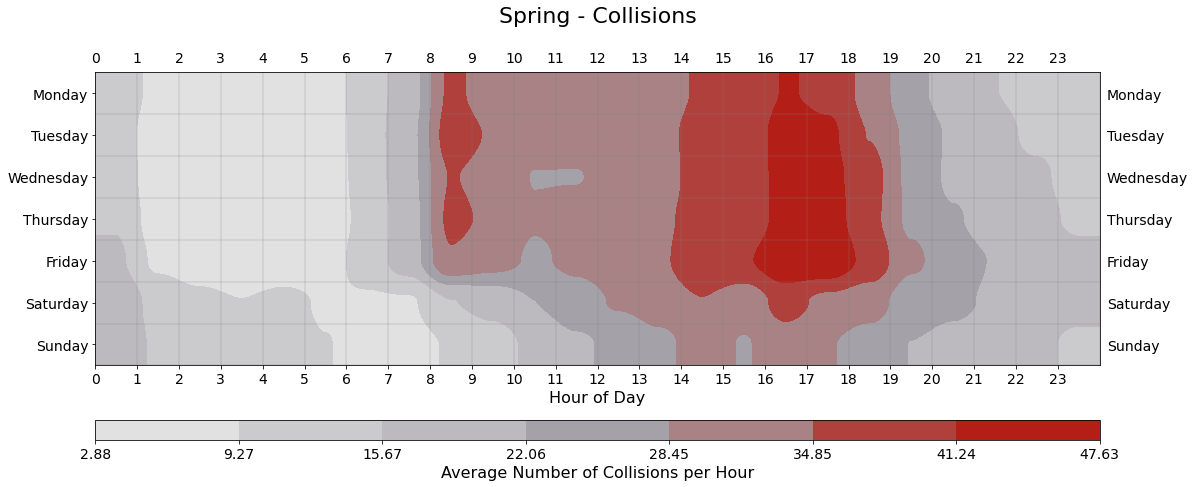

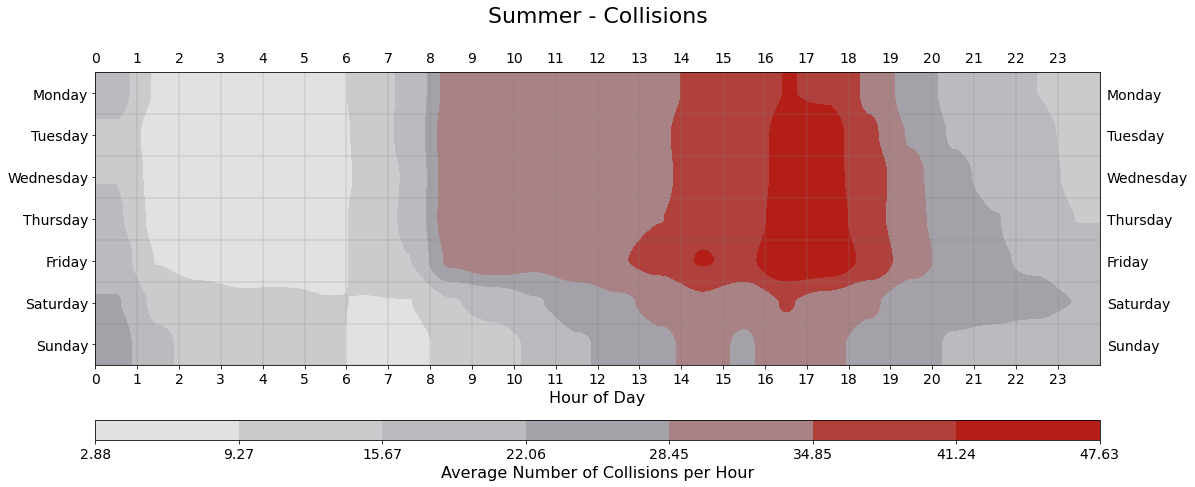

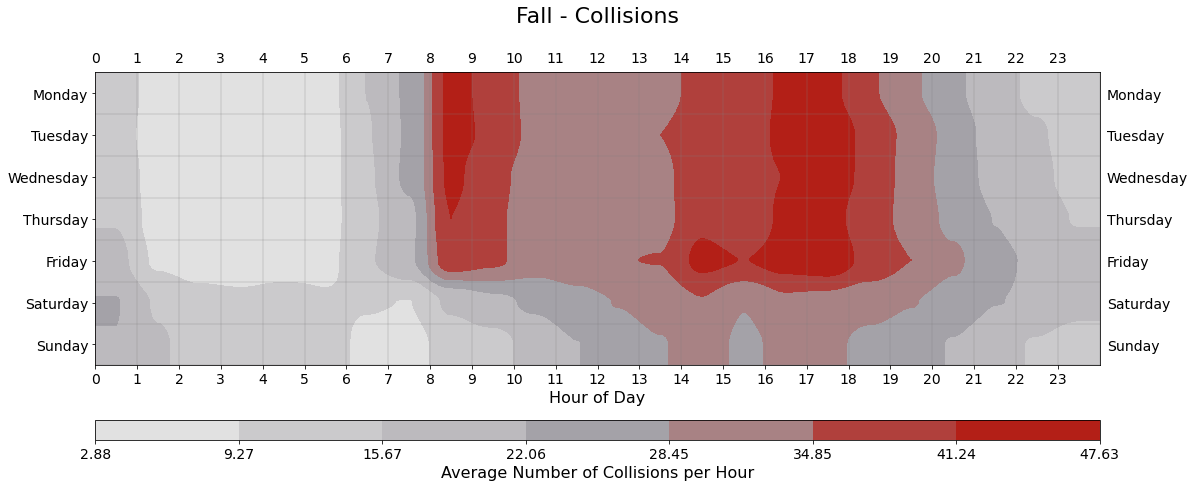

In [19]:
mn_mx_crash = get_crosstab_min_max(
    crashes, "season", SEASONS, divisor=(total_weeks / 4)
)
for season in SEASONS:
    season_df = crashes[crashes["season"] == season]
    season_ct = make_week_crosstab(season_df, (total_weeks / 4))
    season_labels = make_heatmap_labels(
        f"{season} - Collisions", cbar_label="Average Number of Collisions per Hour"
    )
    viz.make_heat_map(
        season_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_crash,
        save=os.path.join(IMG_DIR,  "2D_seasonal", season.lower() + ".png"),
    )

### Weekly Serious Collisions Through the Seasons

- Serious collisions are less common in the winter
- There is a notable cluster of serious collisions during fall weekday mornings
- Summer appears to have more serious collisions at night, ~8pm - 5am (hours 20-5) than other seasons

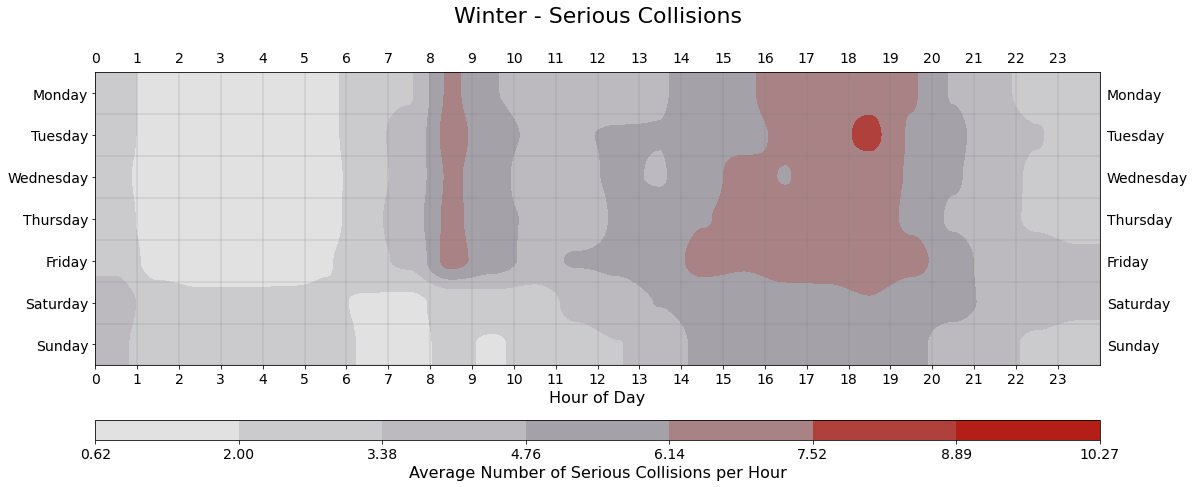

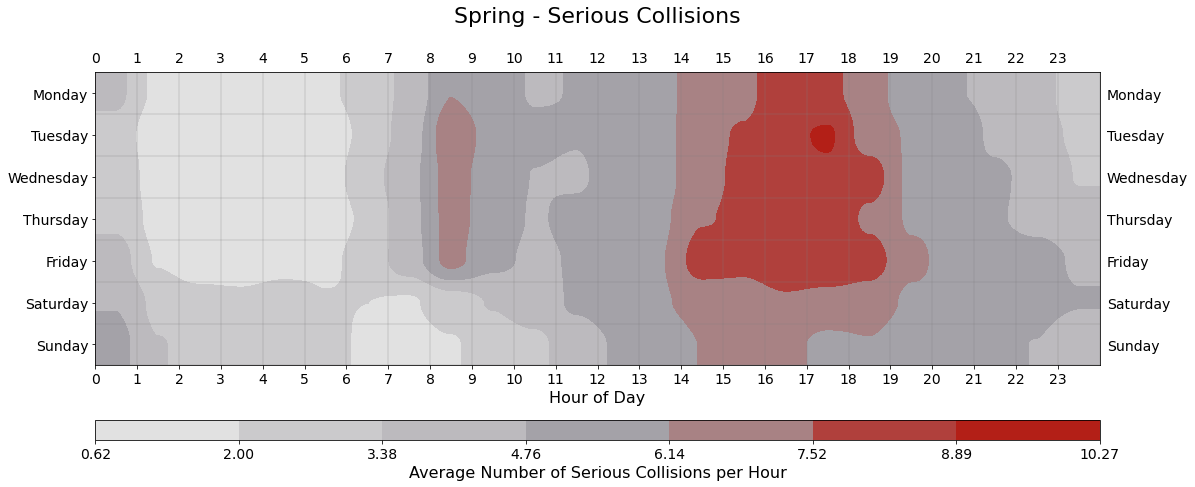

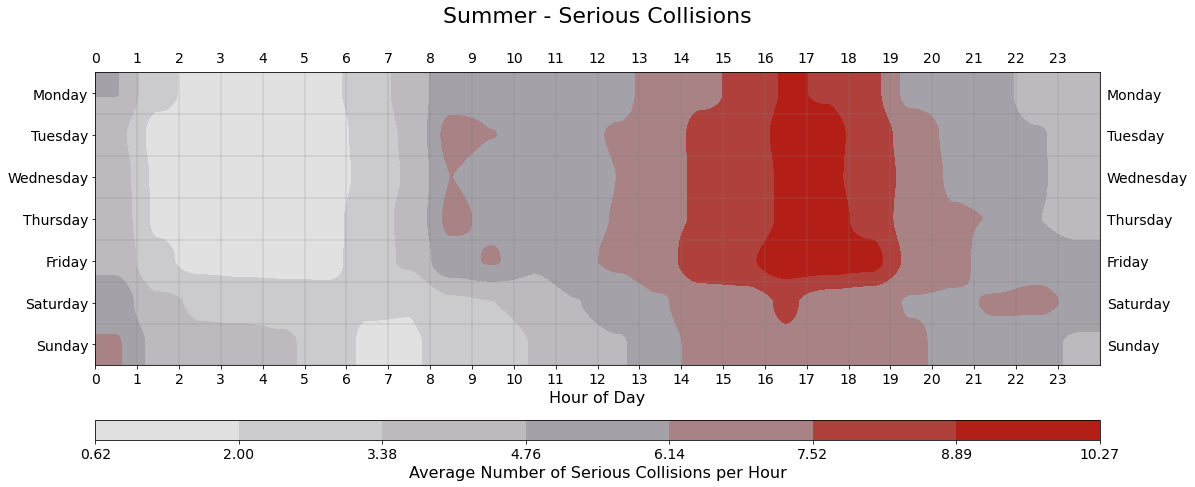

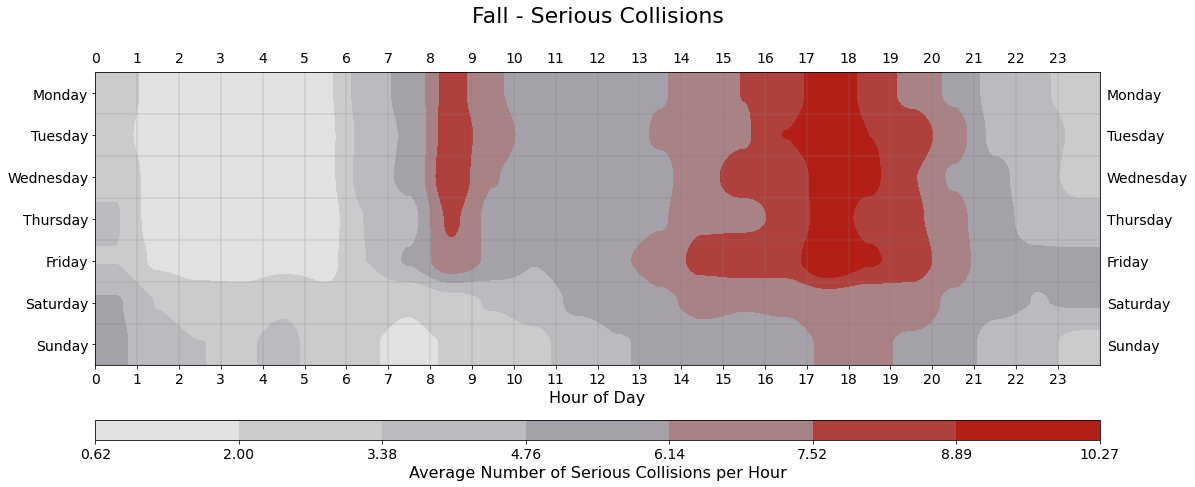

In [20]:
mn_mx_serious = get_crosstab_min_max(
    serious, "season", SEASONS, divisor=(total_weeks / 4)
)
for season in SEASONS:
    season_df = serious[serious["season"] == season]
    season_ct = make_week_crosstab(season_df, (total_weeks / 4))
    season_labels = make_heatmap_labels(
        f"{season} - Serious Collisions",
        cbar_label="Average Number of Serious Collisions per Hour",
    )
    viz.make_heat_map(
        season_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_serious,
        save=os.path.join(IMG_DIR, "2D_seasonal", season.lower() + "_serious.png"),
    )

### Weekly Collisions with Pedestrians and Cyclists Through the Seasons

Pedestrian and cyclist injuries and deaths are particularly concentrated in the fall

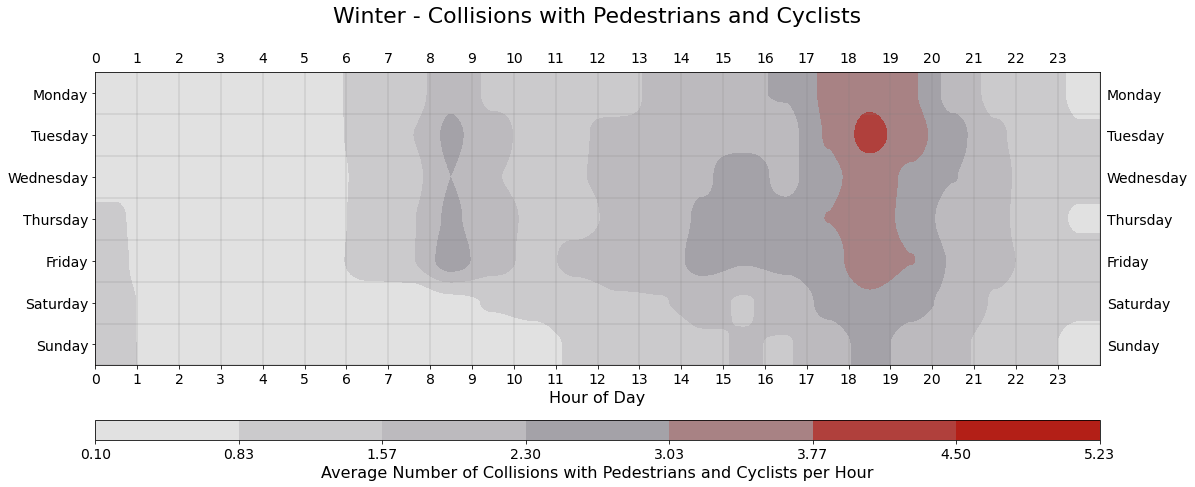

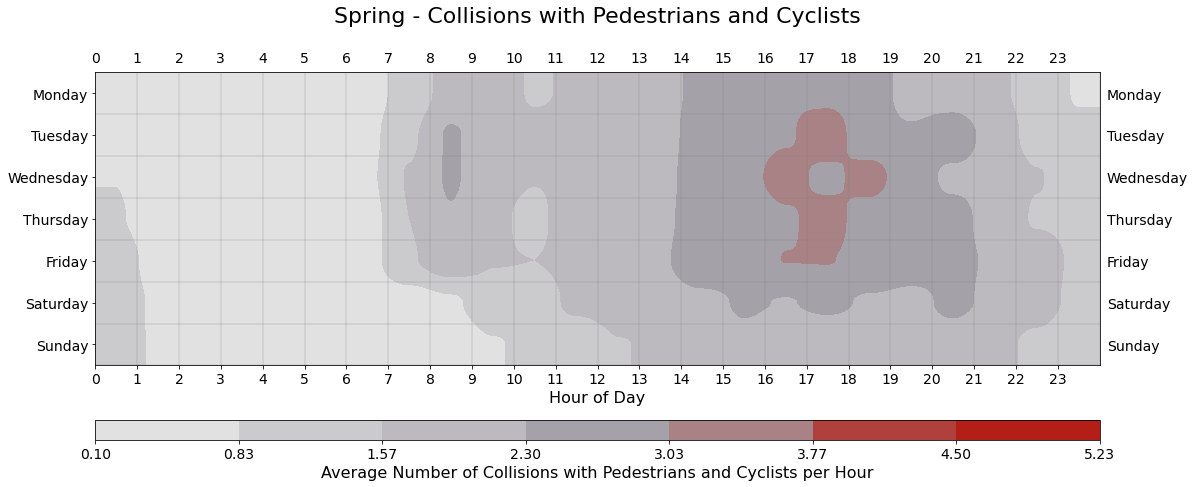

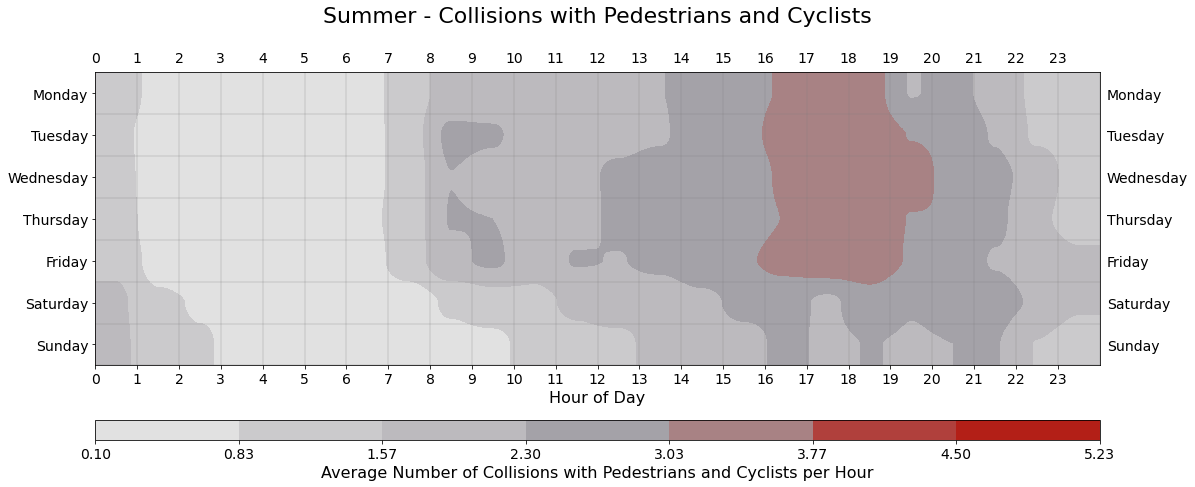

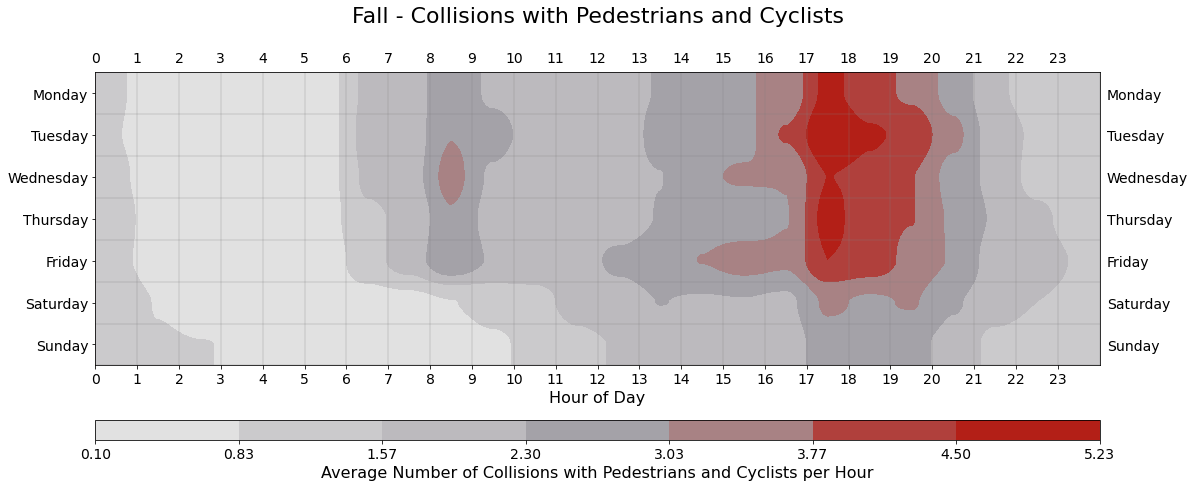

In [21]:
mn_mx_non_motorist = get_crosstab_min_max(
    non_motorist, "season", SEASONS, divisor=(total_weeks / 4)
)
for season in SEASONS:
    season_df = non_motorist[non_motorist["season"] == season]
    season_ct = make_week_crosstab(season_df, (total_weeks / 4))
    season_labels = make_heatmap_labels(
        f"{season} - Collisions with Pedestrians and Cyclists",
        cbar_label="Average Number of Collisions with Pedestrians and Cyclists per Hour",
    )
    viz.make_heat_map(
        season_ct,
        season_labels,
        colors=viz.HEATMAP_COLORS,
        interpolation="hanning",
        min_max=mn_mx_non_motorist,
        save=os.path.join(IMG_DIR, "2D_seasonal", season.lower() + "_non_motorist.png"),
    )

# Conclusions

- Collisions, serious collisions, and serious collisions involving pedestrians or cyclists either trended upwards or were approximately flat from 2013 to 2019 (before COVID)
- Collisions (all categories) are elevated from June through October, with October appearing to be the worst month
- September through November is a particularly bad time for pedestrian and cyclist injuries and deaths
- Fridays have the most collisions (all categories) and Sundays have the fewest
- Collisions (all categories) peak weekday afternoons to early evening
- The weekday morning commute is a secondary cluster of collisions (all categories)
- An elevated number of collisions occur on Saturday and Sunday mornings from midnight to 6am, with a spike in deaths between 4am and 5am



# Follow-Up Questions
- Why are collisions elevated in the summer and fall? 
- Why does October appear to be a particularly bad month?
- What causes the increase in collisions on Friday afternoons and evenings?
- Is intoxication the root cause of spike in deaths from 4am to 5am Saturday and Sunday morning? Are there other contributing factors?